<a href="https://colab.research.google.com/github/abhisheksh1304/Digit-Recognizer-from-Image/blob/main/Ques1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA-SIFT Keypoint Descriptor Implementation

In [ ]:
import numpy as np
from PIL import Image, ImageFilter, ImageDraw, ImageOps
import matplotlib.pyplot as plt
from IPython.display import display
from skimage import io

In [ ]:
image1 = io.imread("img1.png",as_gray=True)
image2 = io.imread("img2.png",as_gray=True)

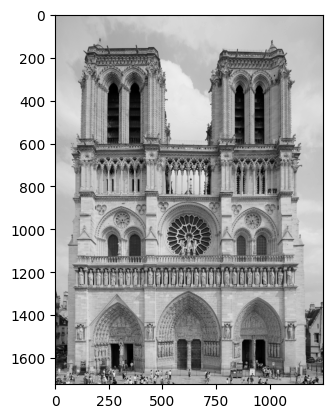

In [ ]:
plt.imshow(image1,cmap='gray')

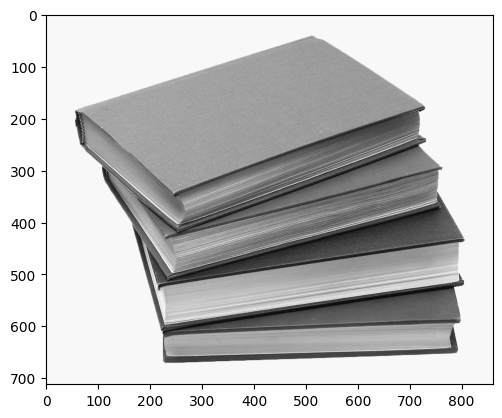

In [ ]:
plt.imshow(image2,cmap='gray')

In [ ]:
import cv2

def downsample_image(image, scale_factor):

    new_width = int(image.shape[1] / scale_factor)
    new_height = int(image.shape[0] / scale_factor)
    downsampled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return downsampled_image


In [ ]:
from scipy.ndimage import gaussian_filter

def gaussian_blurred_octave(image,octave_num,total_octaves):
  sigma=1.6*(2**(octave_num/total_octaves))
  s=8
  k=2**(1/(s-1))
  octave=[]
  for i in range(0,s):
      octave.append(gaussian_filter(image,(k**i)*sigma)*255)
  octave=np.array(octave)
  return octave

In [ ]:
def find_DOG(octave,n):
  dog=[]
  for i in range(1,n):
    dog.append(octave[i]-octave[i-1])

  return dog

In [ ]:
def find_extremas(lower_layer,current_layer,upper_layer,scale):
  rows_num=current_layer.shape[0]
  cols_num=current_layer.shape[1]
  extremas=[]
  for row in range(1,rows_num-1):
    for col in range(1,cols_num-1):
      upper_grid=upper_layer[row-1:row+2,col-1:col+2]
      current_grid=current_layer[row-1:row+2,col-1:col+2]
      lower_grid=lower_layer[row-1:row+2,col-1:col+2]
      current_ele=current_grid[1][1];
      current_grid[1][1]=-1;
      current_max=max(np.max(upper_grid),np.max(current_grid),np.max(lower_grid))
      current_grid[1][1]=256;
      current_min=min(np.min(upper_grid),np.min(current_grid),np.min(lower_grid))
      if current_ele>current_max or current_ele<current_min:
        extremas.append([row,col,scale])

  return extremas


In [ ]:
def find_total_extremas(image):
  blurred_octaves=[]
  dog=[]
  num_of_octaves=3
  scales=8
  for i in range(0,num_of_octaves):
    new_image=downsample_image(image,2**(i/2))
    blurred_octaves.append(gaussian_blurred_octave(new_image,i,num_of_octaves))

  for i in range(0,num_of_octaves):
    dog.append(find_DOG(blurred_octaves[i],scales))

  dog=np.array(dog)
  total_extremas=[]
  for j in range(0,len(dog)):
    for i in range(1,len(dog[j])-1):
      scale=i
      total_extremas.extend(find_extremas(dog[j][i-1].copy(),dog[j][i].copy(),dog[j][i+1].copy(),scale))

  return total_extremas


In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter

def orientation_assigned_keypoints(keypoints, image):

    modified_keypoints = []
    num_bins = 36
    histogram = np.zeros(num_bins)

    Ix = np.gradient(image, axis=1)
    Iy = np.gradient(image, axis=0)

    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    orientation = np.arctan2(Iy, Ix)

    for kp in keypoints:
        x, y, scale = kp

        region_size = int(3 * scale)
        x_min, x_max = max(0, int(x - region_size)), min(image.shape[1] - 1, int(x + region_size))
        y_min, y_max = max(0, int(y - region_size)), min(image.shape[0] - 1, int(y + region_size))

        histogram.fill(0)
        for i in range(x_min, x_max):
            for j in range(y_min, y_max):
                if i < 1 or i >= image.shape[1] - 1 or j < 1 or j >= image.shape[0] - 1:
                    continue
                weight = gaussian_filter(((i - x) ** 2 + (j - y) ** 2) / (2 * scale ** 2), sigma=1.5)
                bin_index = int(np.rad2deg(orientation[j, i]) % 360 / (360 / num_bins))
                if bin_index==36:
                  bin_index=35
                histogram[bin_index] += magnitude[j, i] * weight

        max_orientation = np.argmax(histogram)
        orientation_value = (max_orientation + 0.5) * (360 / num_bins)

        modified_keypoints.append([x, y, scale, orientation_value])

    return modified_keypoints

In [40]:
from google.colab.patches import cv2_imshow
import cv2
from math import sin, cos

def plot_keypoints(image, keypoints):

    for point in keypoints:
        y, x, scale, orientation = point
        cv2.circle(image, (int(x), int(y)), int(scale*0.8), (0, 255, 0), 2)  # Green circle

        line_length = int(scale)
        x_orientation = x + line_length * round(0.5 * scale * cos(orientation))
        y_orientation = y + line_length * round(0.5 * scale * sin(orientation))
        cv2.line(image, (int(x), int(y)), (int(x_orientation), int(y_orientation)), (0, 0, 255), 1)  # Red line

    cv2_imshow(image)


In the plotted image....Green cicles are keypoints and red lines are their orientation

In [ ]:
import cv2
from sklearn.decomposition import PCA

def generate_features(feature_points, image):
    feature_descriptors = []
    for point in feature_points:
        x_coord, y_coord, _, orientation = point  # Extracting x, y, and orientation from feature point
        patch_size = (41, 41)  # Specify patch size

        if x_coord < patch_size[0] // 2 or y_coord < patch_size[1] // 2 or x_coord >= image.shape[1] - patch_size[0] // 2 or y_coord >= image.shape[0] - patch_size[1] // 2:
            continue

        rotation_matrix = cv2.getRotationMatrix2D((x_coord, y_coord), orientation, 1.0)
        rotated_patch = cv2.warpAffine(image, rotation_matrix, (patch_size[0], patch_size[1]), flags=cv2.INTER_LINEAR)
        rotated_patch.resize(39, 39)
        gradient_x = cv2.Sobel(rotated_patch, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(rotated_patch, cv2.CV_64F, 0, 1, ksize=3)

        patch1 = gradient_x.flatten()
        patch2 = gradient_y.flatten()
        patch = np.concatenate((patch1, patch2))
        feature_descriptors.append(patch)

    feature_descriptors = np.array(feature_descriptors)
    return feature_descriptors

def reduce_dimensions_using_PCA(descriptors, num_components=64):
    pca_transformer = PCA(n_components=num_components)
    descriptors_transformed = np.array(pca_transformer.fit_transform(descriptors))
    return descriptors_transformed


For Building Image:

In [ ]:
building_extremas=find_total_extremas(image1)
building_keypoints=orientation_assigned_keypoints(building_extremas,image1)
building_keypoints_descriptors=generate_features(building_keypoints,image1)
PCA_sift_building_keypoints_descriptors=reduce_dimensions_using_PCA(building_keypoints_descriptors)

print("Total Building Keypoints: "+str(len(building_keypoints)))

<ipython-input-11-74ba38016eac>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dog=np.array(dog)


Total Building Keypoints: 11463


In [ ]:
print("Descriptor shape before applying PCA: "+str(building_keypoints_descriptors.shape))
print("Descriptor shape after applying PCA: "+str(PCA_sift_building_keypoints_descriptors.shape))

Descriptor shape before applying PCA: (8889, 3042)
Descriptor shape after applying PCA: (8889, 64)


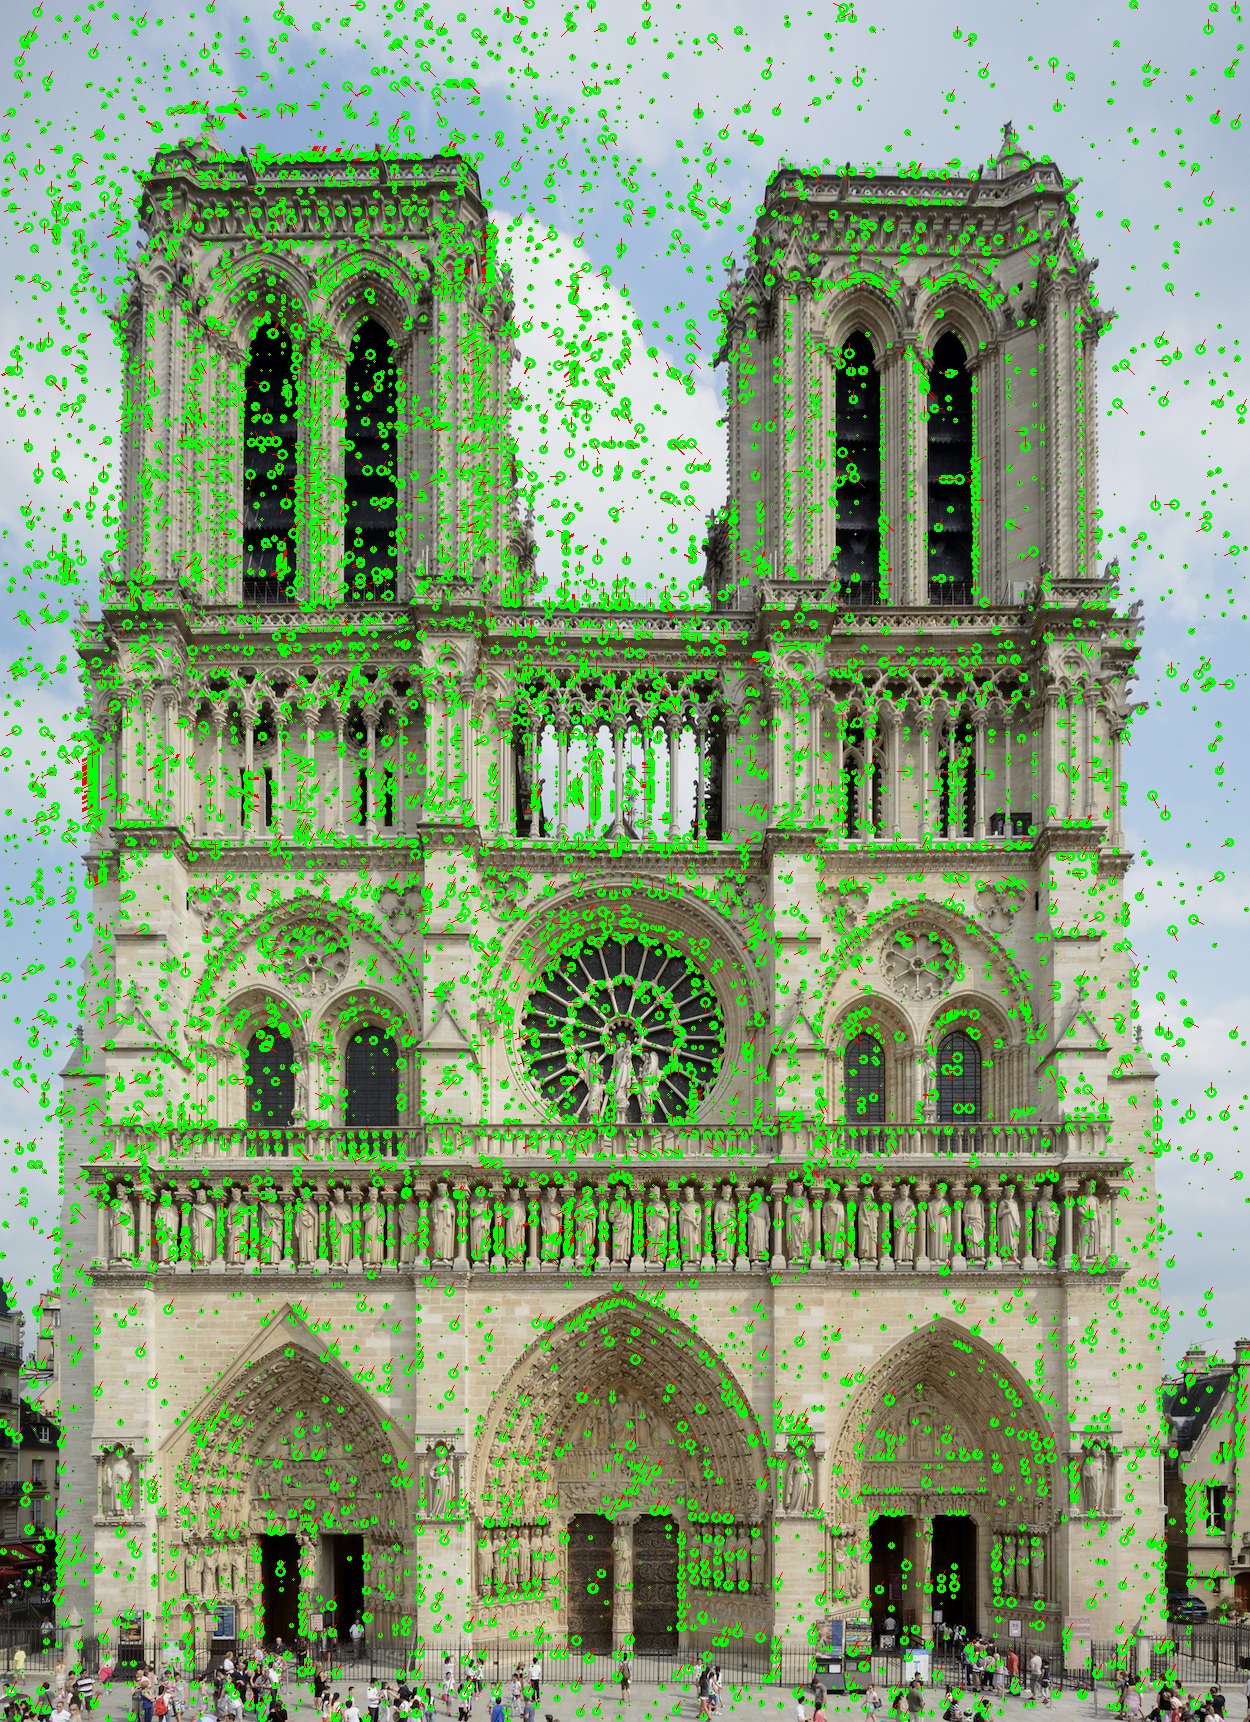

In [41]:
image_1=cv2.imread('img1.png')
plot_keypoints(image_1,building_keypoints)

In [ ]:
book_extremas=find_total_extremas(image2)
book_keypoints=orientation_assigned_keypoints(book_extremas,image2)
book_keypoints_descriptors=generate_features(book_keypoints,image2)
PCA_sift_book_keypoints_descriptors=reduce_dimensions_using_PCA(book_keypoints_descriptors)

print("Total Book Keypoints: "+str(len(book_keypoints)))

<ipython-input-11-74ba38016eac>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dog=np.array(dog)


Total Book Keypoints: 2567


In [ ]:
print("Descriptor shape before applying PCA: "+str(book_keypoints_descriptors.shape))
print("Descriptor shape after applying PCA: "+str(PCA_sift_book_keypoints_descriptors.shape))

Descriptor shape before applying PCA: (2303, 3042)
Descriptor shape after applying PCA: (2303, 64)


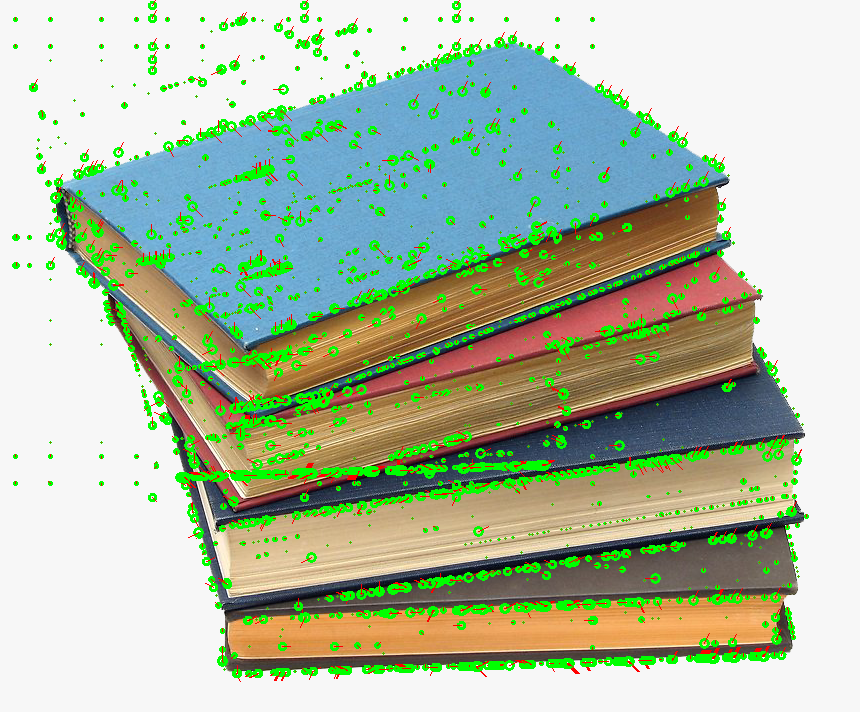

In [42]:
image_2=cv2.imread('img2.png')
plot_keypoints(image_2,book_keypoints)

#Modification of image: Scaling


For Building Image

In [43]:
import skimage
building_downscale = skimage.transform.rescale(image1, 0.5, anti_aliasing=False)
scaled_image_extremas=find_total_extremas(building_downscale )
scaled_image_extremas=np.array(scaled_image_extremas)
scaled_keypoints=orientation_assigned_keypoints(scaled_image_extremas,building_downscale)

print("Total Keypoints in Scaled Building Image: "+str(len(scaled_keypoints)))

<ipython-input-11-74ba38016eac>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dog=np.array(dog)


Total Keypoints in Scaled Building Image: 2863


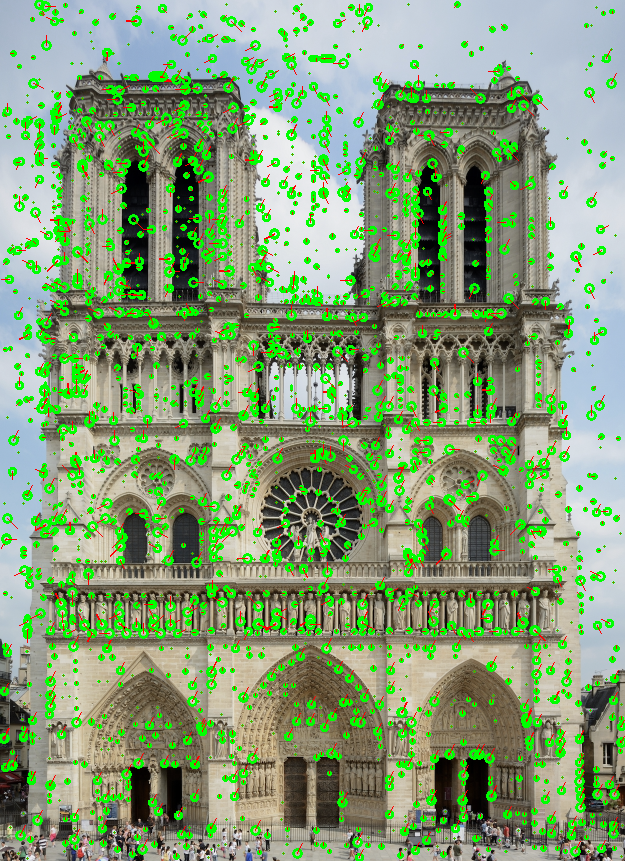

In [44]:
img1=cv2.imread('img1.png')
width = int(img1.shape[1] * 50/ 100)
height = int(img1.shape[0] *50/ 100)
img = cv2.resize(img1, (width, height), interpolation=cv2.INTER_AREA)
plot_keypoints(img,scaled_keypoints)

For Book image

In [ ]:
import skimage
book_downscale = skimage.transform.rescale(image2, 0.5, anti_aliasing=False)
scaled_bookimage_extremas=find_total_extremas(book_downscale )
scaled_bookimage_extremas=np.array(scaled_bookimage_extremas)
scaled_book_keypoints=orientation_assigned_keypoints(scaled_bookimage_extremas,book_downscale)

print("Total Keypoints in Scaled Book Image: "+str(len(scaled_book_keypoints)))

<ipython-input-11-74ba38016eac>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dog=np.array(dog)


In [ ]:
img2=cv2.imread('img2.png')
width = int(img2.shape[1] * 50/ 100)
height = int(img2.shape[0] *50/ 100)
img = cv2.resize(img2, (width, height), interpolation=cv2.INTER_AREA)
plot_keypoints(img,scaled_book_keypoints)

#Modification of image: Rotation

For Building Image

In [ ]:
rotated_building = skimage.transform.rotate(image1, 45)
rotated_image_extremas=find_total_extremas(rotated_building )
rotated_image_extremas=np.array(rotated_image_extremas)
rotated_keypoints=orientation_assigned_keypoints(rotated_image_extremas,rotated_building)

print("Total Keypoints in Rotated Building Image: "+str(len(rotated_keypoints)))

In [ ]:
build_img=cv2.imread('img1.png')
height, width = build_img.shape[:2]
angle=45
rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
rotated_image = cv2.warpAffine(build_img, rotation_matrix, (width, height))
plot_keypoints(rotated_image,rotated_keypoints)

For Book image

In [27]:
rotated_book = skimage.transform.rotate(image2, 45)
rotated_bookimage_extremas=find_total_extremas(rotated_book )
rotated_bookimage_extremas=np.array(rotated_bookimage_extremas)
rotated_book_keypoints=orientation_assigned_keypoints(rotated_bookimage_extremas,rotated_book)

print("Total Keypoints in Rotated Book Image: "+str(len(rotated_book_keypoints)))

In [28]:
book_img=cv2.imread('img2.png')
height, width = book_img.shape[:2]
angle=45
rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
rotated_image = cv2.warpAffine(book_img, rotation_matrix, (width, height))
plot_keypoints(rotated_image,rotated_book_keypoints)

#Modification of image: Blurred

For Building Image

In [29]:
import cv2
blurred_building = gaussian_filter(image1,1.5)*255
blurred_image_extremas=find_total_extremas(blurred_building )
blurred_image_extremas=np.array(blurred_image_extremas)
blurred_keypoints=orientation_assigned_keypoints(blurred_image_extremas,blurred_building)

print("Total Keypoints in Blurred Building Image: "+str(len(blurred_keypoints)))

Total Keypoints in Blurred Building Image: 17896


In [ ]:
img=cv2.imread('img1.png')
blurred_image=cv2.GaussianBlur(img, (15,15), 0)
plot_keypoints(blurred_image,blurred_keypoints)


For Book Image

In [31]:
import cv2
blurred_building = gaussian_filter(image2,1.5)*255
blurred_image_extremas=find_total_extremas(blurred_building )
blurred_image_extremas=np.array(blurred_image_extremas)
blurred_keypoints=orientation_assigned_keypoints(blurred_image_extremas,blurred_building)

print("Total Keypoints in Blurred Book Image: "+str(len(blurred_keypoints)))

In [ ]:
img=cv2.imread('img2.png')
blurred_image=cv2.GaussianBlur(img, (15,15), 0)
plot_keypoints(blurred_image,blurred_keypoints)
